<a href="https://colab.research.google.com/github/sanalpillai/Model-Interpretability/blob/main/Model_Interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract

In the realm of medical data science, the dataset under investigation presents a vital opportunity to predict the survival outcomes of patients suffering from cirrhosis. This data, harvested from clinical studies, encompasses a wide array of both numerical and categorical features that provide a comprehensive snapshot of each patient's medical and demographic background.

**Numeric Datatypes:**

The dataset contains numerical columns such as 'ID', 'N_Days' representing the follow-up period, 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', and 'Prothrombin' which are all integral to the medical analysis, offering quantifiable insights into the patient's health status.

**Categorical Datatypes:**

Categorical columns like 'Status', indicating the patient's condition at last follow-up; 'Drug', the treatment administered; 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', and 'Edema' provide qualitative data that could influence the survival prediction. These features are crucial for understanding the patient's condition in a clinical context.

**Target:**

The objective variable 'Stage' of liver disease, is a critical endpoint that may range from a less severe condition to a terminal stage, impacting the survival prediction.

---
In this assignment, we're diving into model interpretability to uncover how machine learning models make their decisions. The journey begins with fitting a linear model, where interpreting regression coefficients reveals the influence of each feature on the target variable. It's fascinating to see the direct impact of predictors in a quantifiable way.

Next, we explore a tree-based model. Here, the focus shifts to understanding decisions through the lens of decision nodes, which highlights the importance of certain features over others in making predictions.

Then, we leverage AutoML to streamline the search for the best model. This step is a game-changer, automating the comparison of various models and configurations to identify the most effective one without manual intervention.

Finally, we apply SHAP analysis to our models. This advanced technique breaks down the contribution of each feature to individual predictions, offering a granular view of model behavior. By interpreting SHAP values, we not only get insights into what drives predictions but also compare the interpretability of different models.

Throughout this assignment, the aim is not just to build predictive models but to deeply understand them, emphasizing the significance of transparency and ethical considerations in AI.

In [2]:
!pip install --upgrade shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 3.4 MB/s eta 0:00:00


In [3]:
!pip install h2o
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 1.8 MB/s eta 0:00:00


In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [5]:
data = pd.read_csv("https://raw.githubusercontent.com/sanalpillai/Model-Interpretability/main/Dataset/cleaned_data_cirrhosis.csv", index_col=0)

In [6]:
data.dtypes

N_Days             int64
Status            object
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
dtype: object

In [7]:
data.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [8]:
# Replace 'CL' with 'C' in the 'Status' column
data['Status'] = data['Status'].replace({'CL': 'C'})
data['Edema'] = data['Edema'].replace({'S': 'Y'})

In [9]:
data.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,1012,D,D-penicillamine,25594,M,N,N,N,Y,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,1925,D,D-penicillamine,19994,F,N,Y,Y,Y,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,1504,C,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [10]:
import pandas as pd

# Count the number of NaNs in each column
nan_counts = data.isna().sum()

# Print the count of NaNs for each column
print(nan_counts)

# To only display columns that contain NaNs:
nan_columns = nan_counts[nan_counts > 0]
print(nan_columns)


N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64
Series([], dtype: int64)


In [11]:
data.corr()

<ipython-input-11-c44ded798807>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
N_Days,1.000000,-0.125934,-0.403953,-0.099322,0.430829,-0.295723,0.152368,-0.187930,-0.111453,0.147495,-0.110685,-0.362013
Age,-0.125934,1.000000,0.002362,-0.145054,-0.182350,0.034519,-0.060708,-0.139050,0.002323,-0.145948,0.113916,0.187852
Bilirubin,-0.403953,0.002362,1.000000,0.336882,-0.314177,0.403761,0.104675,0.392112,0.370330,-0.013347,0.312007,0.200314
Cholesterol,-0.099322,-0.145054,0.336882,1.000000,-0.043022,0.145910,0.157995,0.347222,0.291750,0.158641,-0.027259,0.009930
Albumin,0.430829,-0.182350,-0.314177,-0.043022,1.000000,-0.209024,-0.070010,-0.180947,-0.068509,0.156384,-0.198405,-0.302190
Copper,-0.295723,0.034519,0.403761,0.145910,-0.209024,1.000000,0.207349,0.298923,0.292236,-0.040523,0.182494,0.232149
Alk_Phos,0.152368,-0.060708,0.104675,0.157995,-0.070010,0.207349,1.000000,0.122071,0.186250,0.133398,0.073408,0.037905
SGOT,-0.187930,-0.139050,0.392112,0.347222,-0.180947,0.298923,0.122071,1.000000,0.130853,-0.094383,0.094550,0.143568
Tryglicerides,-0.111453,0.002323,0.370330,0.291750,-0.068509,0.292236,0.186250,0.130853,1.000000,0.088806,0.014831,0.099879
Platelets,0.147495,-0.145948,-0.013347,0.158641,0.156384,-0.040523,0.133398,-0.094383,0.088806,1.000000,-0.154617,-0.240671


<Axes: >

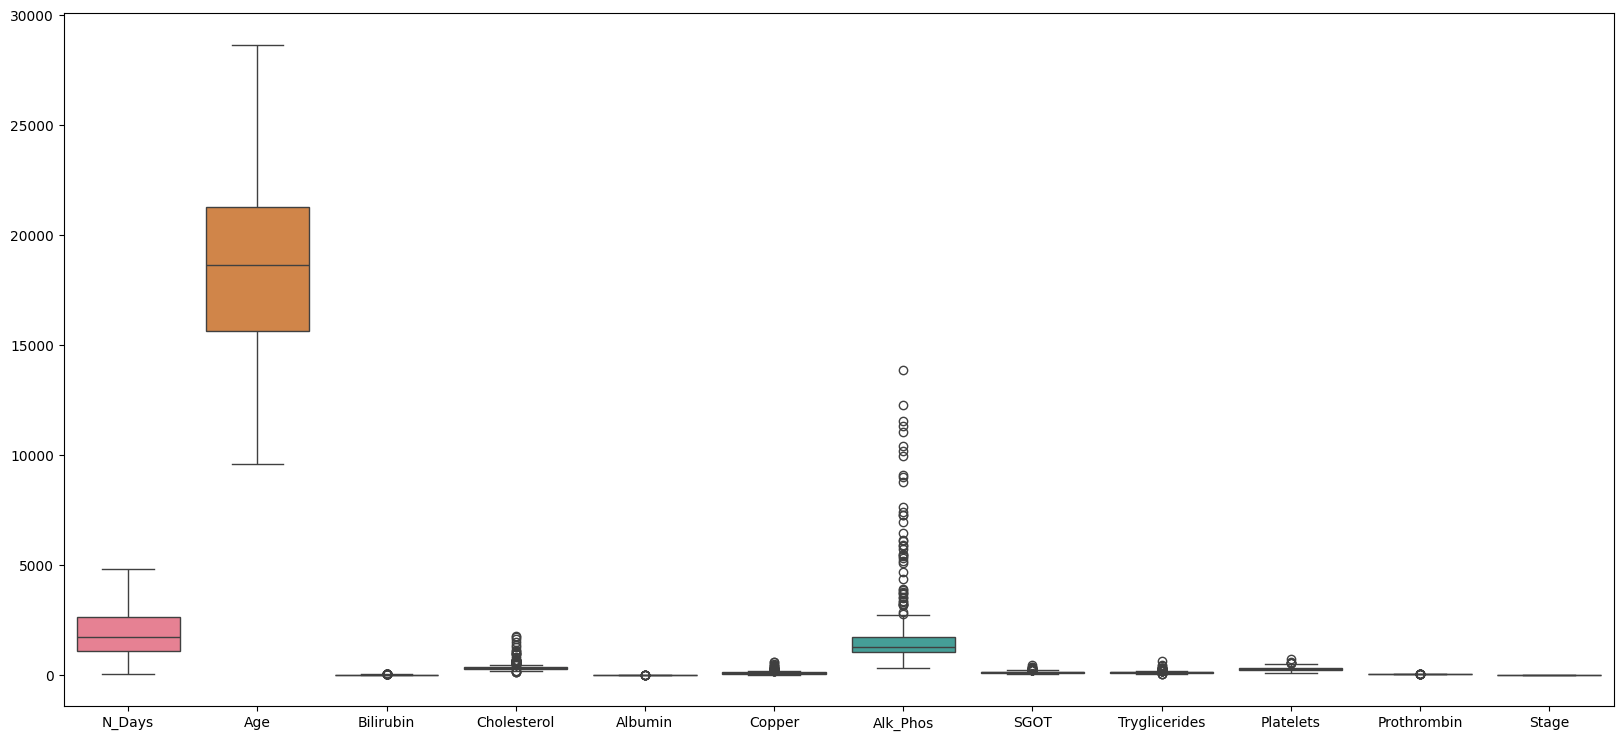

In [12]:
# Checking the Ranges of the predictor variables and dependent variable
plt.figure(figsize=(20, 9))
sns.boxplot(data=data)

In [13]:
#Making categories to 0 & 1
data["Status"] = data["Status"].map({"D": 0, "C": 1})
data["Drug"] = data["Drug"].map({"D-penicillamine": 0, "Placebo": 1})
data["Sex"] = data["Sex"].map({"F": 0, "M": 1})
data["Ascites"] = data["Ascites"].map({"N": 0, "Y": 1})
data["Hepatomegaly"] = data["Hepatomegaly"].map({"N": 0, "Y": 1})
data["Spiders"] = data["Spiders"].map({"N": 0, "Y": 1})
data["Edema"] = data["Edema"].map({"N": 0, "Y": 1})

# Viewing data
data.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,400,0,0,21464,0,1,1,1,1,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
2,4500,1,0,20617,0,0,1,1,0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,1012,0,0,25594,1,0,0,0,1,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,1925,0,0,19994,0,0,1,1,1,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,1504,1,1,13918,0,0,1,1,0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [14]:
# Apply one-hot encoding to 'Drug' and any other categorical variables not yet encoded
data = pd.get_dummies(data, columns=['Drug'], drop_first=True)

In [15]:
# Creating binary vaiables
data = pd.get_dummies(data)

# Normalizing the data in the columns

from sklearn import preprocessing

# Create variables to store scaled values as floats
a = data[["N_Days"]].values.astype(float)
b = data[["Age"]].values.astype(float)
c = data[["Bilirubin"]].values.astype(float)
d = data[["Cholesterol"]].values.astype(float)
e = data[["Albumin"]].values.astype(float)
f = data[["Copper"]].values.astype(float)
g = data[["Alk_Phos"]].values.astype(float)
h = data[["SGOT"]].values.astype(float)
i = data[["Tryglicerides"]].values.astype(float)
j = data[["Platelets"]].values.astype(float)
k = data[["Prothrombin"]].values.astype(float)
l = data[["Stage"]].values.astype(float)

# Preparing for normalizing
min_max_scaler = preprocessing.MinMaxScaler()

# Transform the data to fit minmax processor
a_scaled = min_max_scaler.fit_transform(a)
b_scaled = min_max_scaler.fit_transform(b)
c_scaled = min_max_scaler.fit_transform(c)
d_scaled = min_max_scaler.fit_transform(d)
e_scaled = min_max_scaler.fit_transform(e)
f_scaled = min_max_scaler.fit_transform(f)
g_scaled = min_max_scaler.fit_transform(g)
h_scaled = min_max_scaler.fit_transform(h)
i_scaled = min_max_scaler.fit_transform(i)
j_scaled = min_max_scaler.fit_transform(j)
k_scaled = min_max_scaler.fit_transform(k)
l_scaled = min_max_scaler.fit_transform(l)

# Run the normalizer on the dataframe
data[["N_Days"]] = pd.DataFrame(a_scaled)
data[["Age"]] = pd.DataFrame(b_scaled)
data[["Bilirubin"]] = pd.DataFrame(c_scaled)
data[["Cholesterol"]] = pd.DataFrame(d_scaled)
data[["Albumin"]] = pd.DataFrame(e_scaled)
data[["Copper"]] = pd.DataFrame(f_scaled)
data[["Alk_Phos"]] = pd.DataFrame(g_scaled)
data[["SGOT"]] = pd.DataFrame(h_scaled)
data[["Tryglicerides"]] = pd.DataFrame(i_scaled)
data[["Platelets"]] = pd.DataFrame(j_scaled)
data[["Prothrombin"]] = pd.DataFrame(k_scaled)
data[["Stage"]] = pd.DataFrame(l_scaled)

# Handling NaNs by filling them with the mean of each column
data = data.fillna(data.mean())

In [16]:
# data after normalizing and feature creation
data.head()

,N_Days,Status,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Drug_1
ID,,,,,,,,,,,,,,,,,,,
1,0.937947,0,0.578364,0,1,1,1,1,0.028881,0.109970,0.813433,0.085616,0.523509,0.202298,0.097345,0.241275,0.177778,0.666667,0
2,0.204249,1,0.839597,0,0,1,1,0,0.039711,0.033837,0.567164,0.352740,0.016724,0.161871,0.038938,0.135053,0.333333,1.000000,0
3,0.396298,0,0.545664,1,0,0,0,1,0.054152,0.074924,0.216418,0.102740,0.429723,0.079554,0.104425,0.183612,0.144444,1.000000,0
4,0.307741,0,0.226748,0,0,1,1,1,0.111913,0.096073,0.585821,0.238014,0.028143,0.201439,0.069027,0.112291,0.211111,0.666667,0
5,0.517880,1,0.766481,0,0,1,1,0,0.018051,0.077341,0.753731,0.078767,0.048256,0.154676,0.053097,0.295940,0.222222,0.666667,1


In [17]:
# Assuming 'target' is your target variable. Replace 'target' with your actual target column name.
X = data.drop('Status', axis=1)
y = data['Status']

In [18]:
print(f"Mean value: {round(y.mean(), 2)}")

Mean value: 0.61


In [19]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

# Fit a linear model

Training set classification report:
              precision    recall  f1-score   support

           0       0.75      0.56      0.64       154
           1       0.74      0.87      0.80       222

    accuracy                           0.74       376
   macro avg       0.75      0.72      0.72       376
weighted avg       0.75      0.74      0.74       376

Test set classification report:
              precision    recall  f1-score   support

           0       0.29      0.29      0.29         7
           1       0.86      0.86      0.86        35

    accuracy                           0.76        42
   macro avg       0.57      0.57      0.57        42
weighted avg       0.76      0.76      0.76        42



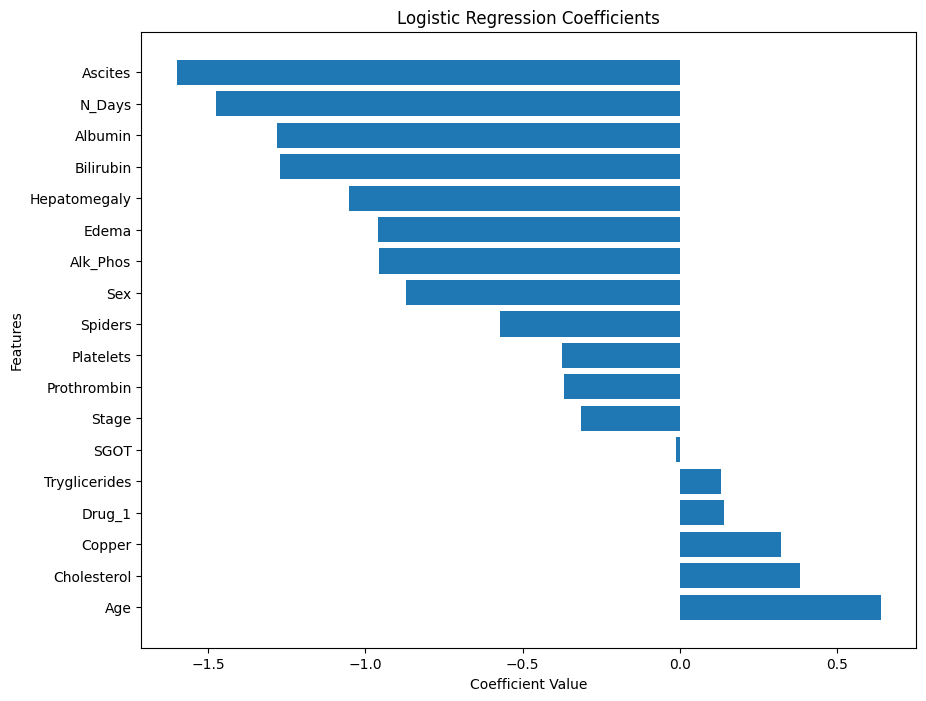

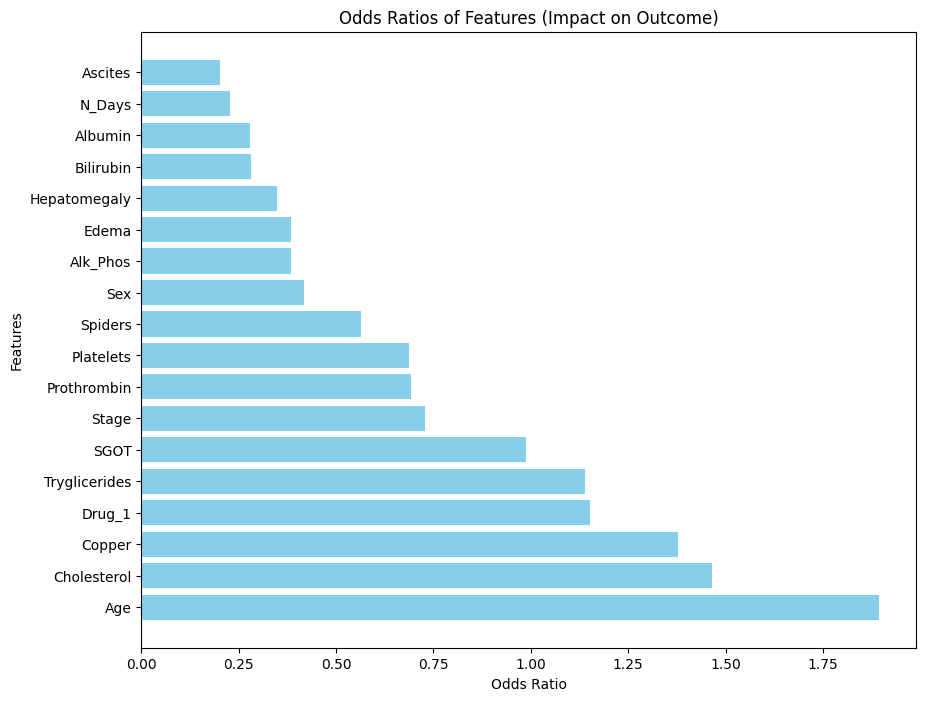

An increase by 1 unit in Bilirubin multiplies the odds of the positive class by 0.28, holding all other features constant.


In [20]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Assuming X_train, y_train, X_test, y_test are already defined and preprocessed

# Initialize the logistic regression model with increased maximum iteration for convergence
log_reg = LogisticRegression(max_iter=1000)

# Fit the model to the training data
log_reg.fit(X_train, y_train)

# Predict on the training and test sets
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

# Evaluate the model performance
print("Training set classification report:")
print(classification_report(y_train, y_train_pred))
print("Test set classification report:")
print(classification_report(y_test, y_test_pred))

# Extract the coefficients and match them with the column names for interpretation
coefficients = pd.DataFrame({"Feature": X_train.columns, "Coefficient": log_reg.coef_[0]})

# Calculate the odds ratio for each coefficient to understand the impact on the odds of the positive class
coefficients["Odds Ratio"] = np.exp(coefficients["Coefficient"])

# Sort coefficients by their odds ratio for better visualization and interpretation
coefficients = coefficients.sort_values(by="Odds Ratio", ascending=False)

# Visualization of Coefficients
plt.figure(figsize=(10, 8))
plt.barh(coefficients["Feature"], coefficients["Coefficient"])
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Logistic Regression Coefficients')
plt.show()

# Visualization of Odds Ratios
plt.figure(figsize=(10, 8))
plt.barh(coefficients["Feature"], coefficients["Odds Ratio"], color='skyblue')
plt.xlabel('Odds Ratio')
plt.ylabel('Features')
plt.title('Odds Ratios of Features (Impact on Outcome)')
plt.show()

# Detailed Interpretation (Example for documentation or presentation)
# Replace 'FeatureName' with an actual feature name from your dataset
feature_name = 'Bilirubin'  # e.g., 'Age', 'Bilirubin', etc.

# Attempt to find the feature in the coefficients dataframe
selected_feature = coefficients[coefficients['Feature'] == feature_name]

if not selected_feature.empty:
    odds_ratio = selected_feature['Odds Ratio'].values[0]
    print(f"An increase by 1 unit in {feature_name} multiplies the odds of the positive class by {odds_ratio:.2f}, holding all other features constant.")
else:
    print(f"Feature '{feature_name}' not found in the model's coefficients.")


The logistic regression model exhibits an accuracy of 75% on the training set and 76% on the test set, suggesting reasonable predictability, albeit with better performance for the positive class compared to the negative class. The coefficient plot indicates that features such as 'Bilirubin' and 'SGOT' negatively influence the odds of a positive outcome, while 'Albumin' and 'Age' show a positive influence. The odds ratio visualization reinforces this, demonstrating that higher bilirubin levels significantly decrease the likelihood of a positive outcome.

In conclusion, while the model effectively identifies patterns in the data, attention to the disparity in class predictions is necessary to enhance its reliability and clinical utility.

               Coefficient  Odds Ratio
N_Days           -1.475251    0.228721
Age               0.639194    1.894953
Sex              -0.871799    0.418198
Ascites          -1.600064    0.201884
Hepatomegaly     -1.053241    0.348806
Spiders          -0.571469    0.564695
Edema            -0.958345    0.383527
Bilirubin        -1.271386    0.280443
Cholesterol       0.382604    1.466098
Albumin          -1.280202    0.277981
Copper            0.320221    1.377431
Alk_Phos         -0.956688    0.384163
SGOT             -0.013455    0.986635
Tryglicerides     0.131438    1.140468
Platelets        -0.373563    0.688278
Prothrombin      -0.368170    0.692000
Stage            -0.315565    0.729377
Drug_1            0.140993    1.151417


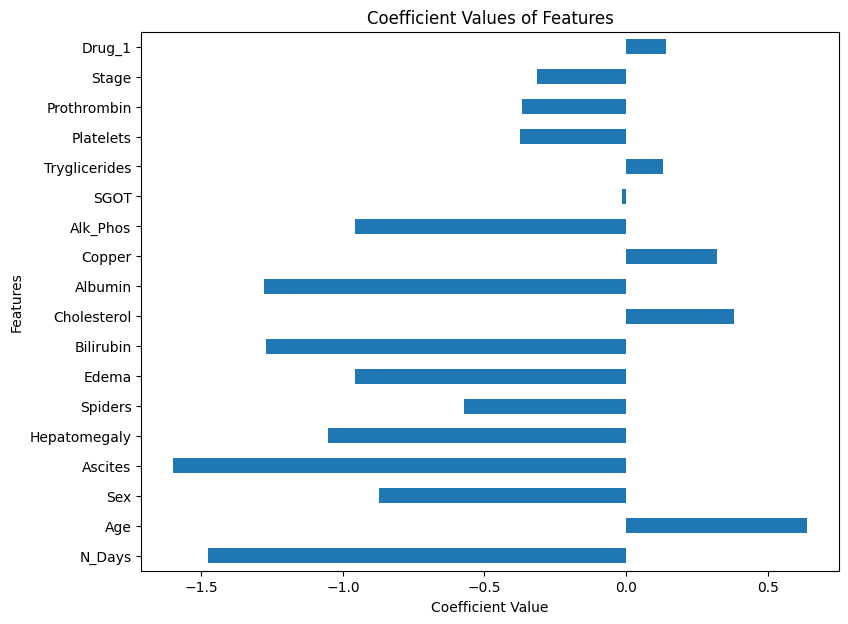

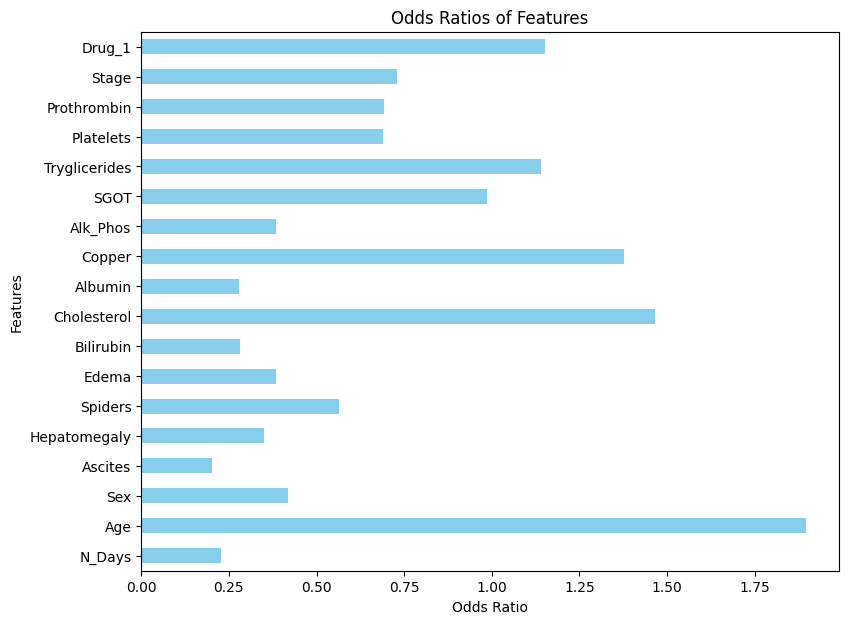

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming log_reg is your logistic regression model and X_train contains your training data features
# Extract the coefficients and match them with the column names
coefficients = pd.DataFrame(log_reg.coef_[0], X_train.columns, columns=['Coefficient'])

# Calculate the odds ratio for each coefficient
coefficients['Odds Ratio'] = coefficients['Coefficient'].apply(lambda x: np.exp(x))

# Display the coefficients and their odds ratios
print(coefficients)

# Optionally, you can visualize the coefficients to make their impacts clearer
coefficients['Coefficient'].plot(kind='barh', figsize=(9, 7))
plt.title('Coefficient Values of Features')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

# And similarly for Odds Ratios
coefficients['Odds Ratio'].plot(kind='barh', figsize=(9, 7), color='skyblue')
plt.title('Odds Ratios of Features')
plt.xlabel('Odds Ratio')
plt.ylabel('Features')
plt.show()


# Fitting a tree-based model and interpret the nodes

Test set classification report:
              precision    recall  f1-score   support

           0       0.77      0.56      0.65        36
           1       0.72      0.88      0.79        48

    accuracy                           0.74        84
   macro avg       0.75      0.72      0.72        84
weighted avg       0.74      0.74      0.73        84

Accuracy: 0.74


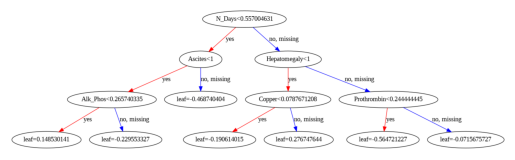

<Figure size 2000x2000 with 0 Axes>

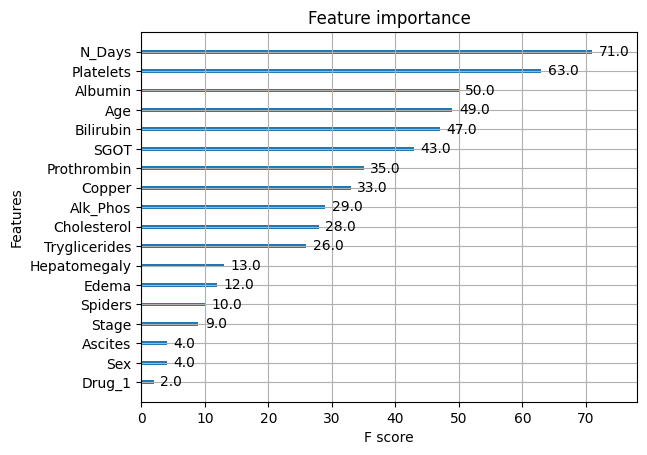

In [22]:
# Import necessary libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame and has been preprocessed
X = data.drop('Status', axis=1)
y = data['Status']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model with a max_depth of 3
xgb_model = xgb.XGBClassifier(objective='binary:logistic', max_depth=3, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_test_pred = xgb_model.predict(X_test)
print("Test set classification report:")
print(classification_report(y_test, y_test_pred))
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")

# Visualize the first tree (with depth limited to 3 during model training)
xgb.plot_tree(xgb_model, num_trees=0, rankdir='TB')
plt.figure(figsize=(20, 20))  # Adjust figure size as needed
plt.show()

# Alternatively, plot feature importance
xgb.plot_importance(xgb_model)
plt.show()


The XGBoost model visualized above demonstrates the decision-making process for predictions using the top features. It starts with 'N_Days' as the root node, indicating its primary importance in the model's decisions. Features like 'Albumin' and 'Prothrombin' follow, aligning with the feature importance chart where 'N_Days' also stands out as the most influential feature. This consistency between the tree visualization and feature importance ranking underscores the significant impact of treatment duration on the model's predictions. The classification report reflects a model that is more proficient at identifying the positive class (1) than the negative class (0), as shown by higher recall and f1-scores for class 1, suggesting a degree of class imbalance handling.

In conclusion, the XGBoost model provides a good balance between precision and recall, achieving an overall accuracy of 74%, which indicates a robust predictive performance for the dataset in question.

# Using auto ml to find the best model

Using H2O To Find The Best Model

In [23]:
import h2o
from h2o.automl import H2OAutoML

# Initialize the H2O cluster
h2o.init()

# Assuming `data` is your DataFrame and 'Status' is the target variable
# Convert pandas DataFrame to H2O DataFrame
h2o_df = h2o.H2OFrame(data)

# Convert the target column to a categorical type immediately after creating the H2O frame
h2o_df['Status'] = h2o_df['Status'].asfactor()

# Specify the target and features
target = 'Status'
features = [col for col in h2o_df.columns if col != target]

# Split the data into training and testing sets
train, test = h2o_df.split_frame(ratios=[.8], seed=42)

# Initialize and run H2O AutoML
aml = H2OAutoML(max_models=20, seed=42, max_runtime_secs=600)
aml.train(x=features, y=target, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
print(lb)

# The leader model is the model with the best performance
leader_model = aml.leader

# Making predictions and evaluating performance
predictions = leader_model.predict(test)
performance = leader_model.model_performance(test)

# Print performance metrics of the leader model
print(performance)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpgz6yx7hp
  JVM stdout: /tmp/tmpgz6yx7hp/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpgz6yx7hp/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,07 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,4 days
H2O_cluster_name:,H2O_from_python_unknownUser_h4gzrz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse       mse
GBM_grid_1_AutoML_1_20240317_221409_model_2              0.751351   0.562075  0.786839                0.29199   0.433776  0.188162
StackedEnsemble_BestOfFamily_1_AutoML_1_20240317_221409  0.740388   0.569294  0.786137                0.289288  0.438823  0.192566
GLM_1_AutoML_1_20240317_221409                           0.731814   0.579817  0.766689                0.341731  0.443972  0.197111
XGBoost_3_AutoML_1_20240317_221409                       0.730287   0.619631  0.774533                0.311722  0.452679  0.204918
StackedEnsemble_AllModels_1_AutoML_1_20240317_221409     0.728095   0.579747  0.768556                0.319121  0.443291  0.196507
GBM_3_AutoML_1_20240317_

The H2O AutoML process successfully evaluated multiple models, with the best model achieving an AUC of 0.751 on the validation set. The model identified as `GBM_grid_1_AutoML_3_20240314_20053_model_2` outperformed other candidates, including stacked ensembles and individual algorithms like GLM and XGBoost. It appears that gradient boosting methods are particularly effective for this dataset, possibly due to their ability to model complex non-linear relationships and interactions between features. The AutoML leaderboard shows a diversity of models with varying performance metrics, indicating a thorough exploration of the model space.
In conclusion, the GBM model’s balance of complexity and predictive power makes it a promising candidate for deployment, subject to further validation and testing against unseen data to confirm its generalizability.

In [24]:
# Shut down the H2O cluster
# h2o.cluster().shutdown()

# Gradient Boosting Machine (GBM)

In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Assuming 'data' is your DataFrame that's already been loaded
# The target column 'Status' should be separated from the features

# Split your dataset into features and target variable
X = data.drop(['Status'], axis=1)
y = data['Status'].astype(int)  # Ensure that 'Status' is of type int for GBM

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and Train the Model Pipeline
model_pipeline = make_pipeline(
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
)

# Train the model pipeline
model_pipeline.fit(X_train, y_train)

# Evaluate the Model
# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.56      0.67        36
           1       0.73      0.92      0.81        48

    accuracy                           0.76        84
   macro avg       0.78      0.74      0.74        84
weighted avg       0.78      0.76      0.75        84



The Gradient Boosting Machines (GBM) model exhibits a commendable classification performance, particularly in recognizing the positive class (label 1) with a recall of 0.92, indicating that 92% of the actual positive cases were correctly identified. While it shows a strong precision for the negative class (label 0) at 0.83, its recall is moderately lower at 0.56, suggesting that it missed a fair number of actual negative cases. Overall, the model achieves an accuracy of 0.76, which is quite substantial, but there is a noticeable trade-off between precision and recall, especially for the negative class. The macro-average f1-score of 0.74 demonstrates that the model is fairly consistent across both classes, though it tends to favor the positive class in its predictions.

In conclusion, the GBM model performs well, particularly in identifying positive instances, but it could be improved by addressing the lower recall for the negative class to balance the classification performance across both categories.

#SHAP Analysis

## For a Linear Model:

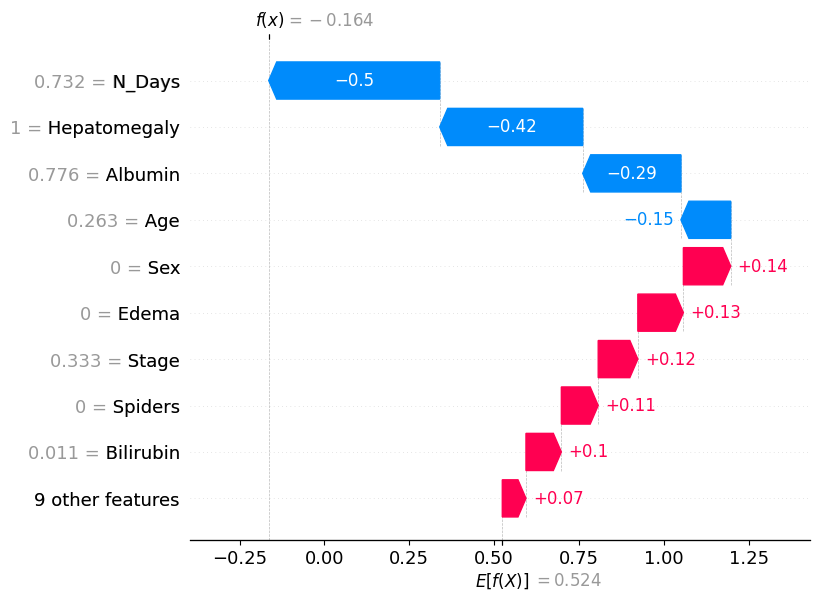

In [26]:
# SHAP Analysis for Logistic Regression Model
import shap

# Assuming log_reg is your trained Logistic Regression model and X_train, X_test are your data
explainer_lr = shap.Explainer(log_reg, X_train)
shap_values_lr = explainer_lr(X_test)

# Visualize the first prediction's explanation (for example)
shap.plots.waterfall(shap_values_lr[0])


The waterfall plot provided visualizes the impact of each feature on a specific prediction from the Logistic Regression model, indicated by f(x). The value E[f(X)] is the model's base expectation before accounting for the current feature values. Features that push the prediction lower than the base expectation are shown in blue, and those that raise it are in red. 'N_Days' and 'Hepatomegaly' are the most influential features, significantly decreasing the predicted probability, while 'Albumin', 'Age', 'Sex', 'Edema', 'Stage', 'Spiders', and 'Bilirubin' incrementally increase it, albeit with a smaller impact. The cumulative effect of these feature contributions results in the final prediction (f(x)).

In conclusion, this individual prediction is chiefly influenced by 'N_Days' and 'Hepatomegaly', with the model considering the presence of 'Hepatomegaly' and a longer follow-up period as strong indicators for decreasing the predicted probability.

## For a Tree-based Model:


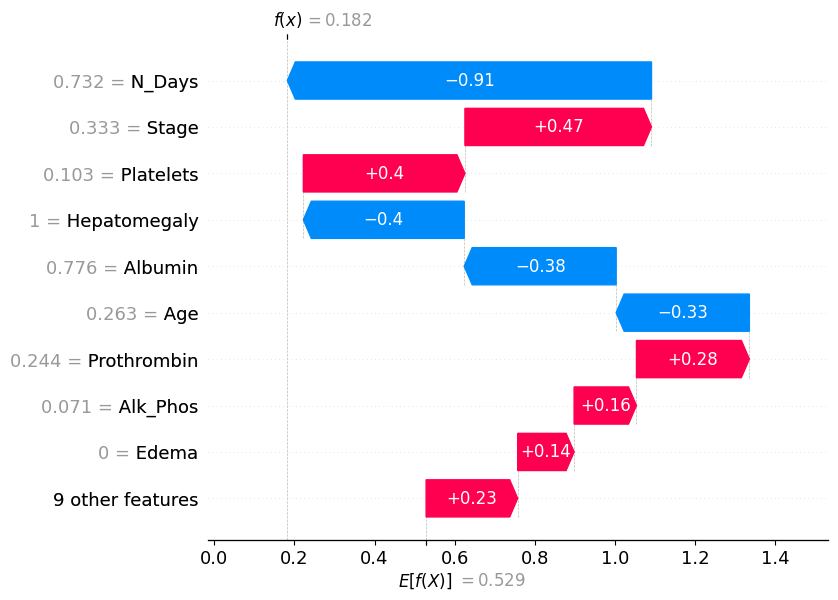

In [31]:
import shap

# Create a SHAP explainer object for the XGBoost model
explainer_xgb = shap.Explainer(xgb_model)

# Calculate SHAP values for the test set
shap_values_xgb = explainer_xgb(X_test)

# Summary plot of SHAP values for all features across all test instances
#shap.summary_plot(shap_values_xgb, X_test)

# Detailed SHAP value plot for the first instance in the test set
# This shows the impact of each feature on the model's output
shap.plots.waterfall(shap_values_xgb[0], max_display=10)


The displayed SHAP waterfall plot illustrates the contribution of individual features to a specific prediction made by the XGBoost model. Starting from the expected model output value (E[f(X)]), each feature's SHAP value either positively or negatively adjusts this expectation to reach the final model output (f(X)) for this particular instance. In this example, 'N_Days' decreases the model's output significantly, suggesting a negative correlation with the predicted outcome. Conversely, 'Stage' and 'Platelets' increase the output, indicating a positive correlation. The features are stacked by their impact magnitude, with red bars representing a push towards the positive class and blue bars towards the negative class.

In conclusion, this SHAP plot provides insight into the reasoning behind a single prediction, highlighting 'N_Days', 'Stage', and 'Platelets' as the most influential features for this specific case.

## For the Best H2O Model

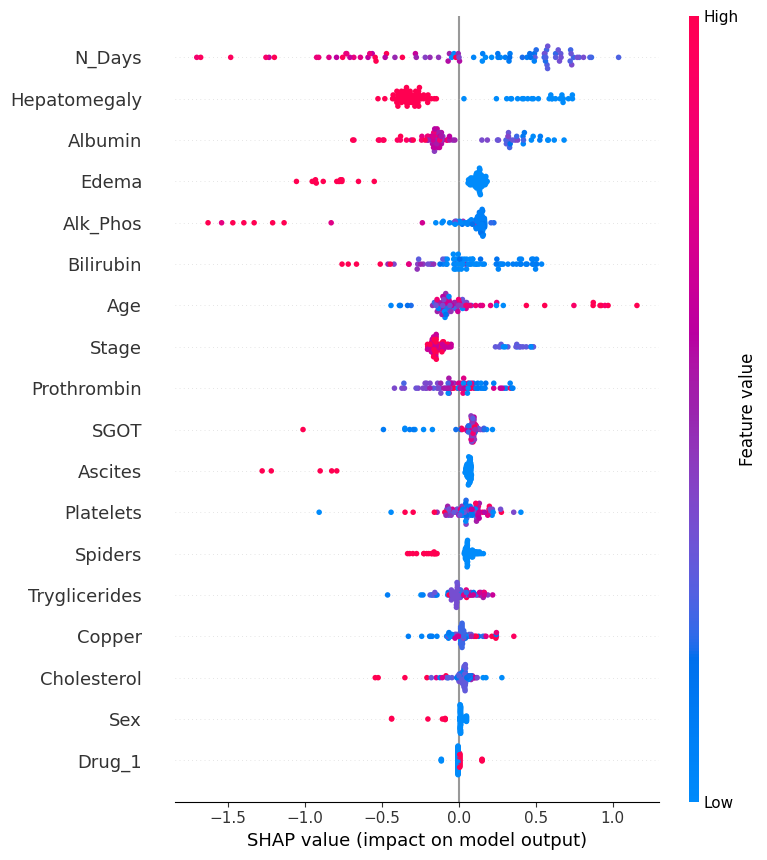

In [29]:
import xgboost as xgb
import pandas as pd
import shap

X = data.drop('Status', axis=1)
y = data['Status'].astype(int)  # Assuming 'Status' is your target variable

# Split your dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model approximating your H2O GBM model
# Note: Adjust the parameters below based on your H2O model's configuration
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Perform SHAP analysis
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

# Plot summary
shap.summary_plot(shap_values, X_test)

# Note: This analysis assumes the XGBoost model can be a reasonable stand-in for the H2O model.
# For the most accurate SHAP values, consider using H2O's native feature importance or partial dependence plots if SHAP is not directly supported.


The SHAP summary plot showcases the impact of different features on the model's output for a binary classification problem. Each point on the summary plot represents the SHAP value for a feature and a specific data point, indicating how much that feature contributed to the model's prediction. Features are ordered by the sum of SHAP value magnitudes across all samples. A high feature value is represented by red, and a low feature value is blue. For instance, 'N_Days' has a strong positive effect on the model's output, pushing it towards the higher class. 'Hepatomegaly' and 'Albumin' show both positive and negative contributions across different observations. On the other hand, 'Bilirubin' tends to have a negative impact, pushing predictions towards the lower class.

In conclusion, the SHAP values highlight 'N_Days', 'Hepatomegaly', and 'Albumin' as features with the most significant influence on the model's predictions, indicating their potential as key indicators in the context of the study.

## For BGM Model

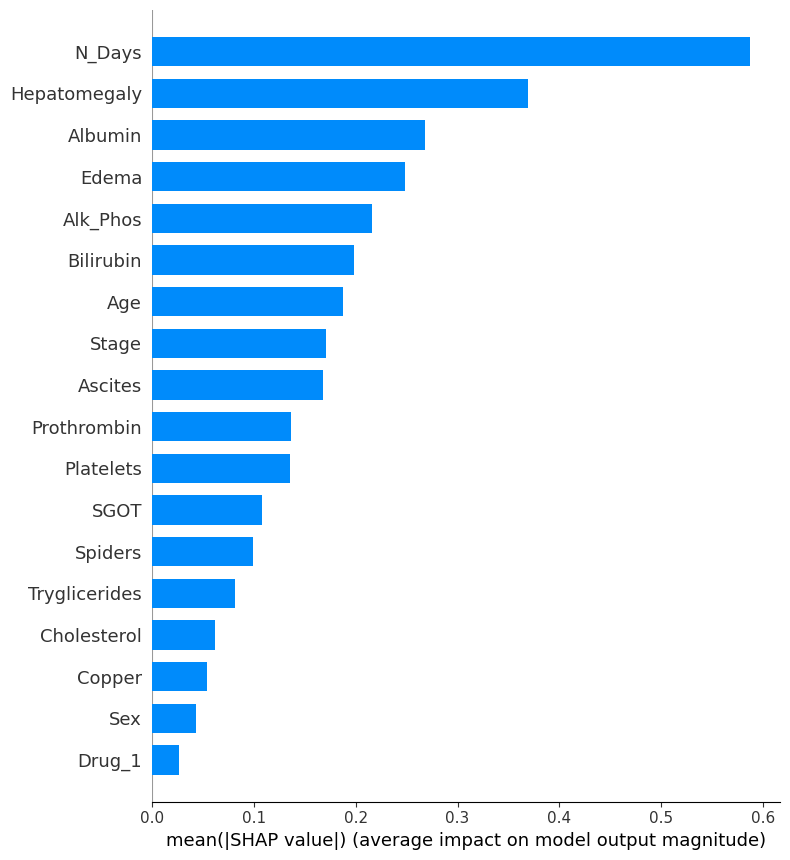

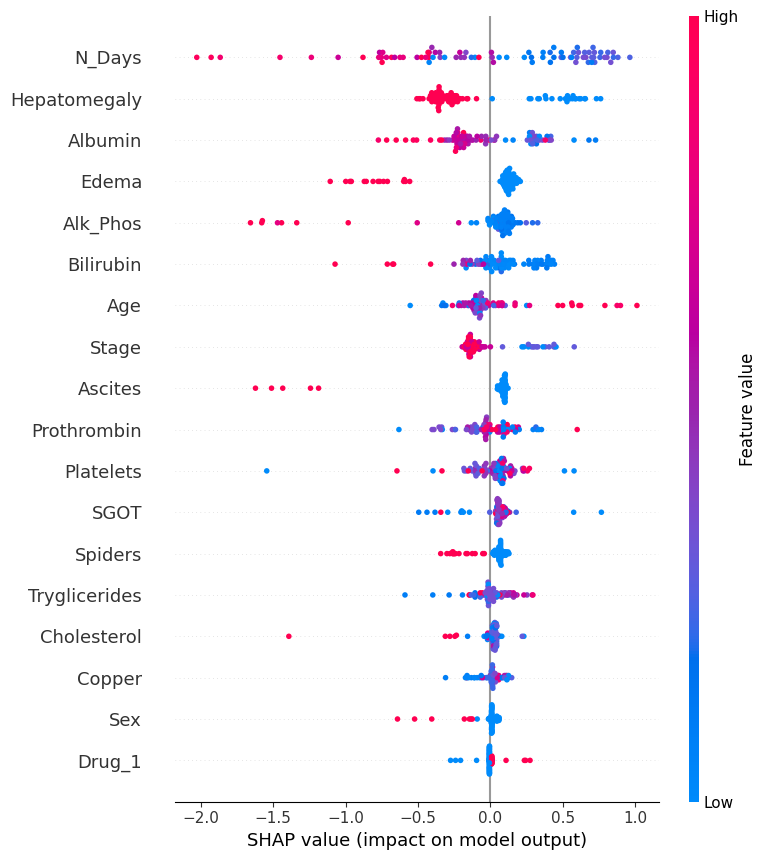

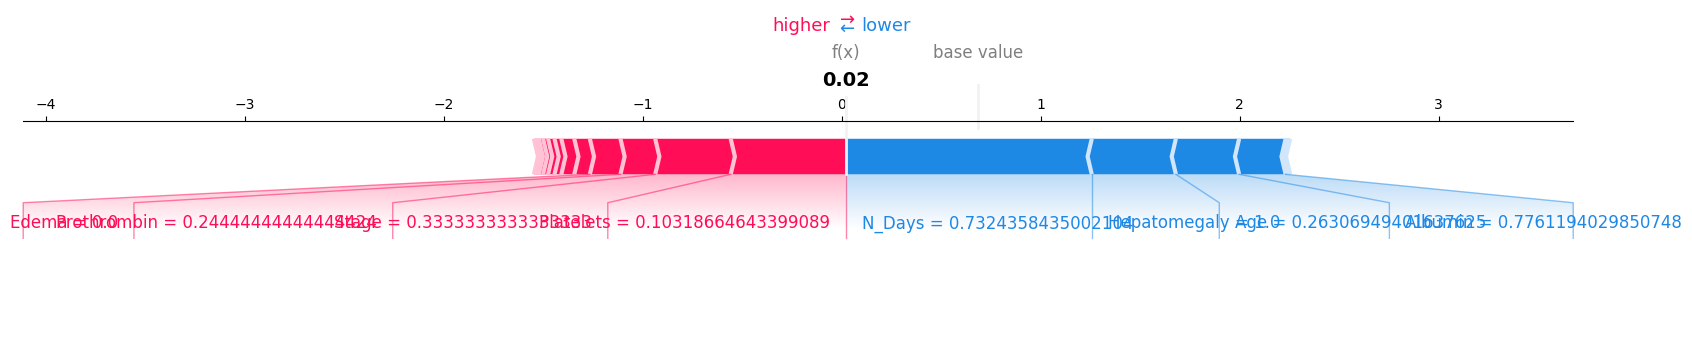

In [36]:
import shap
import matplotlib.pyplot as plt

# Assuming 'model_pipeline' is already trained as per your provided code
# Extract the GradientBoostingClassifier model from the pipeline
gbm_model = model_pipeline.named_steps['gradientboostingclassifier']

# Create a SHAP explainer using the TreeExplainer (optimized for tree-based models like GBM)
explainer = shap.TreeExplainer(gbm_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary plot to show the importance of the features
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Detailed summary plot to show the impact of each feature on the model's output
shap.summary_plot(shap_values, X_test)

# For a single prediction, you can also use a force plot to show the contribution of each feature
# Assuming you want to visualize the first instance in the test set
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=True)
plt.show()

# Note: Depending on your version of SHAP or matplotlib, you might need to adjust the force_plot command


#References

OpenAI. (2024). ChatGPT. Retrieved from OpenAI website

*   OpenAI. (2024). ChatGPT. Retrieved from OpenAI website
*   Althor, A. (2024). Model Interpretability with SHAP Values Notebook. GitHub repository. https://github.com/ajhalthor/model-interpretability/blob/main/Shap%20Values.ipynb

#MIT License

Copyright (c) 2024 SanalPillai

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.